In [23]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import GridSearchCV,train_test_split,RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,recall_score,f1_score,precision_score,confusion_matrix,roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from catboost import CatBoostClassifier
import shap
from xgboost import XGBClassifier

In [24]:
df = pd.read_csv("F:/dataset_for_ML/Ensemble Learning/classification/breastcancerpredictionwinconsin.csv")

In [25]:
df.drop(columns=["id","Unnamed: 32"],inplace=True)

In [26]:
X = df.iloc[:,1:]
y = df["diagnosis"]

In [27]:
le = LabelEncoder()
y = le.fit_transform(y)

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)

In [29]:
xgb = XGBClassifier(random_state=42)

In [30]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}


In [31]:
model = RandomizedSearchCV(estimator=xgb,param_distributions=param_dist,n_iter=20,scoring="accuracy",cv=5,verbose=1,n_jobs=-1)

In [32]:
model.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 8],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='accuracy', verbose=1)

In [33]:
pred = model.predict(X_test)

In [34]:
model.best_score_,model.best_params_

(0.9758241758241759,
 {'subsample': 0.6,
  'n_estimators': 500,
  'min_samples_split': 10,
  'min_samples_leaf': 1,
  'max_features': 'log2',
  'max_depth': 8,
  'learning_rate': 0.1})

<Axes: >

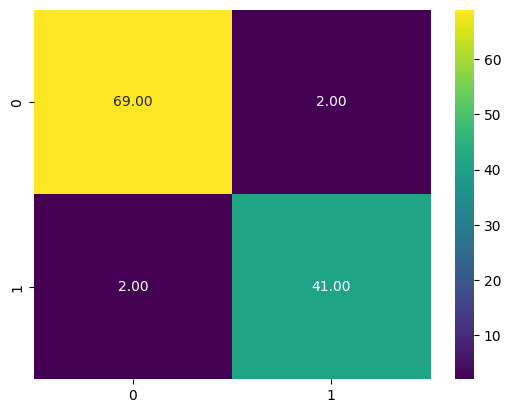

In [35]:
sns.heatmap(confusion_matrix(pred,y_test),cmap="viridis",fmt='.2f',annot=True)

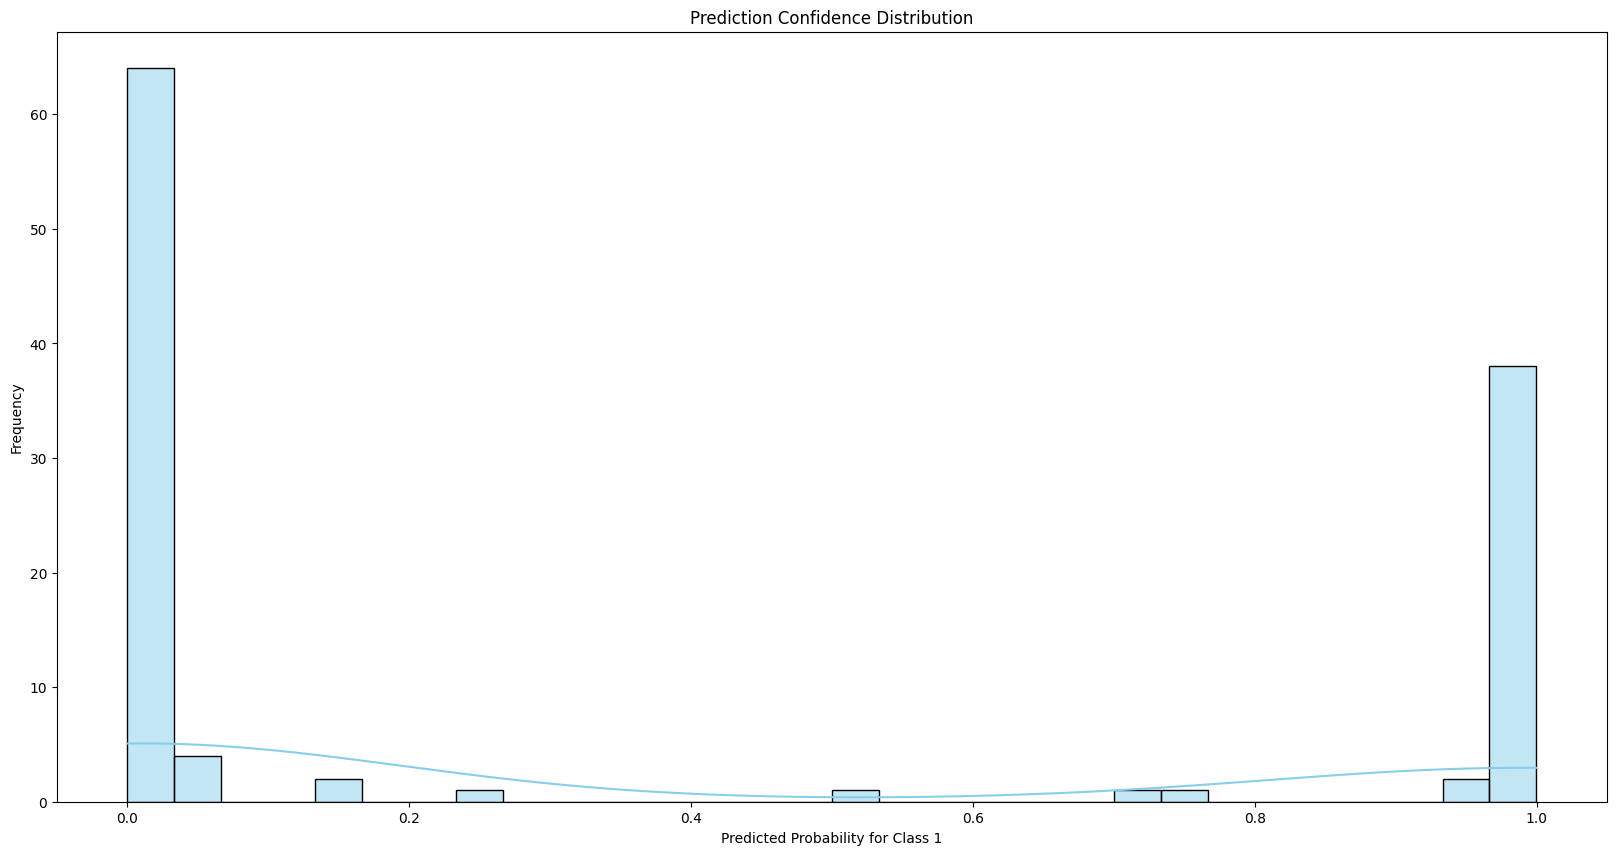

In [36]:
# same as catplot
import seaborn as sns


y_probs = model.predict_proba(X_test)[:, 1]
plt.figure(figsize=(20,10))
sns.histplot(y_probs, bins=30, kde=True, color="skyblue")
plt.xlabel("Predicted Probability for Class 1")
plt.ylabel("Frequency")
plt.title("Prediction Confidence Distribution")
plt.show()



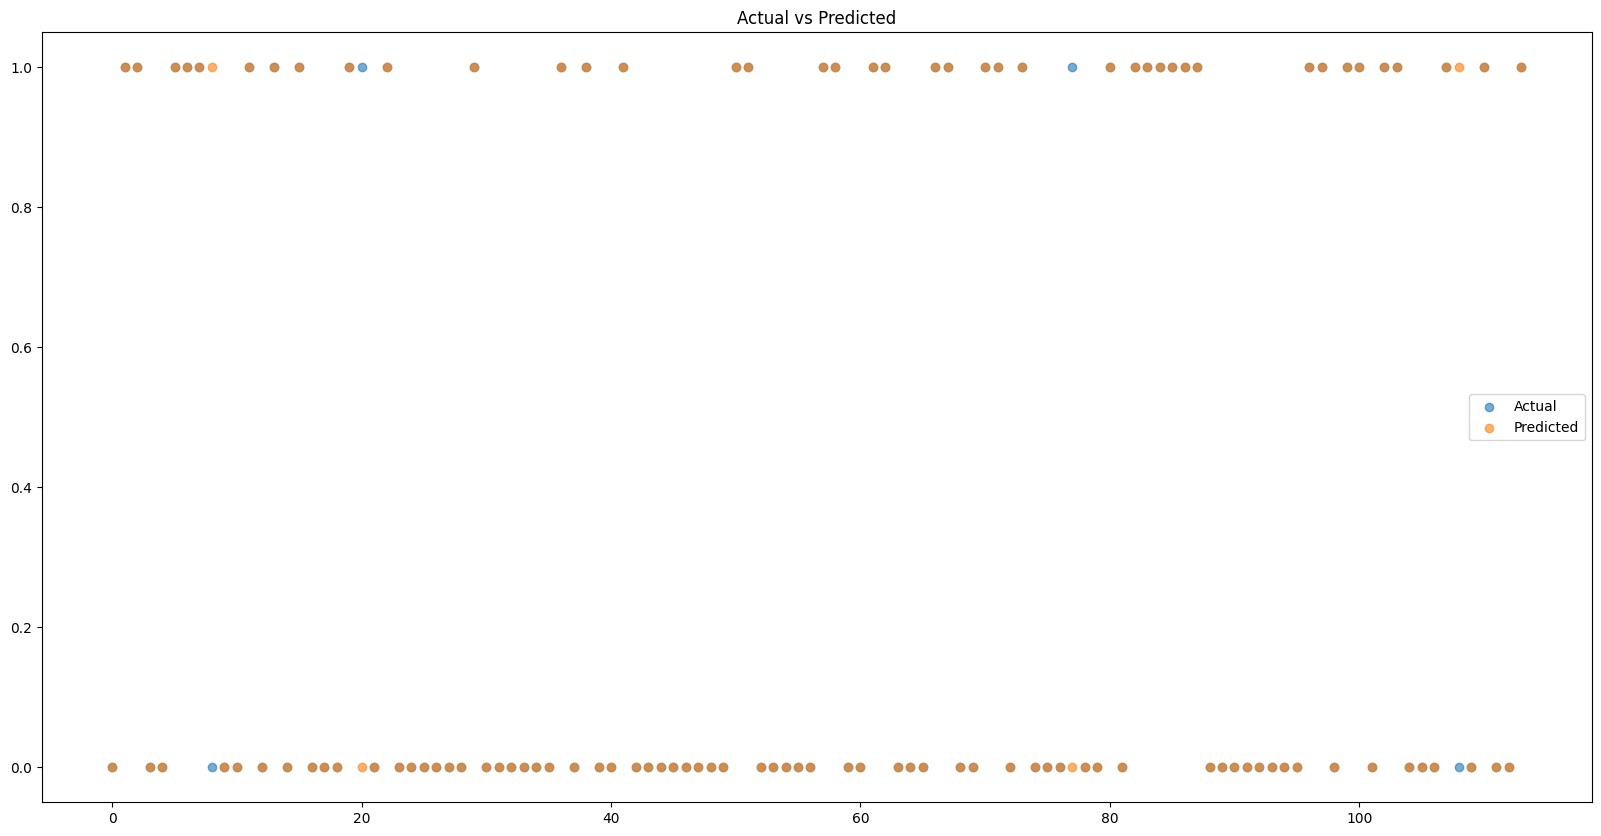

In [37]:
## created a df for actual and predicted values , 
df_pred = pd.DataFrame({
    'Actual': y_test,
    'Predicted': pred
})
plt.figure(figsize=(20,10))
plt.scatter(range(len(y_test)), y_test, label='Actual', alpha=0.6)
plt.scatter(range(len(pred)), pred, label='Predicted', alpha=0.6)
plt.legend()
plt.title("Actual vs Predicted")
plt.show()


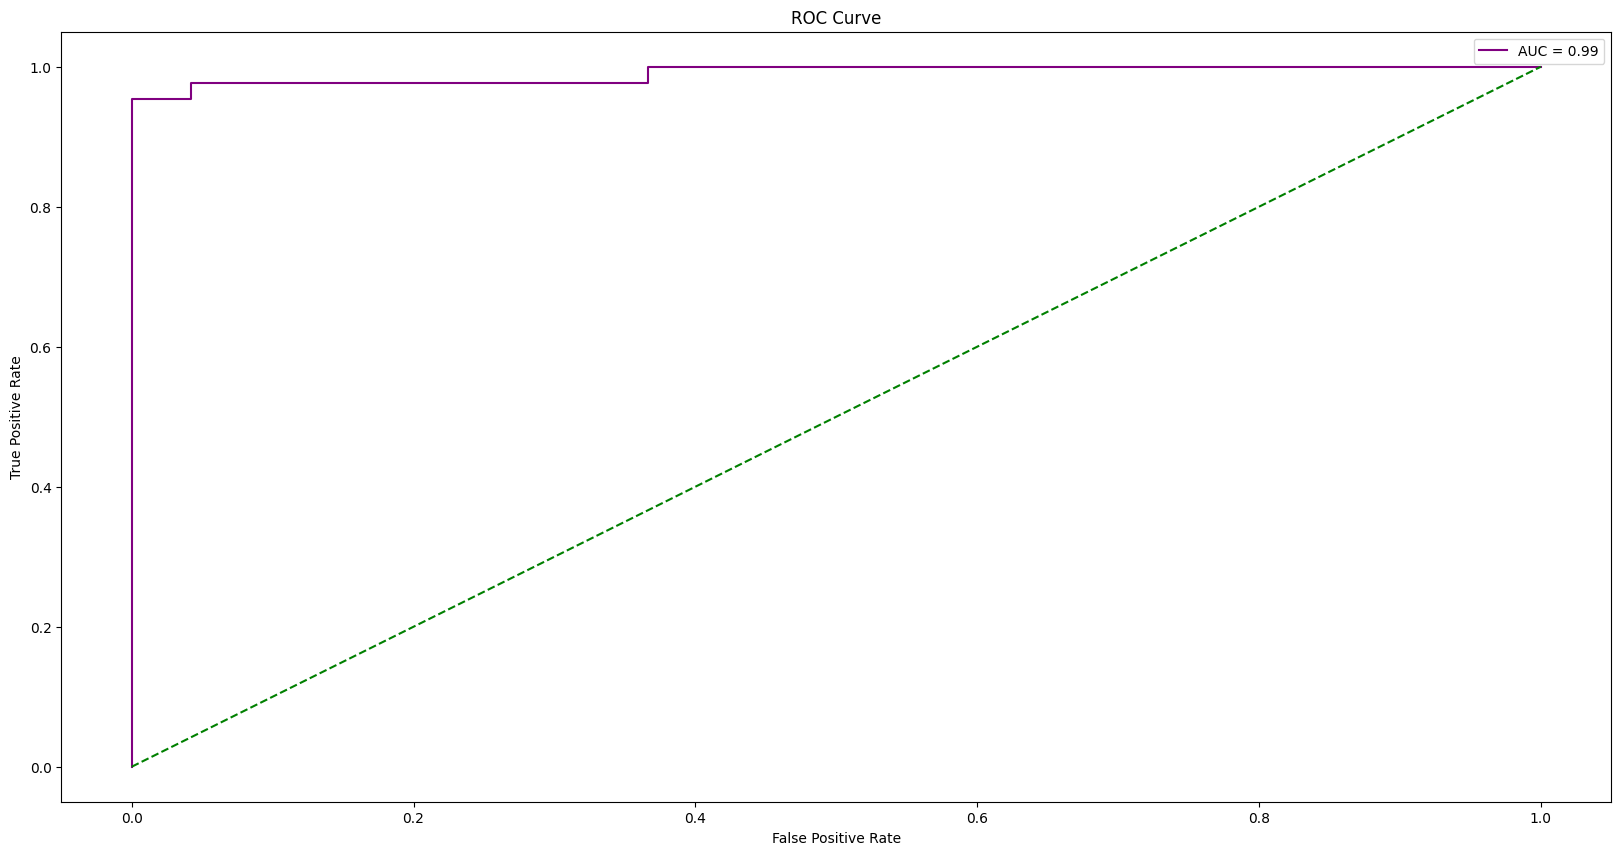

In [38]:
#### ROC CURVE

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
# print("fpr",fpr)
# print("tpr",tpr)
# print("_",_)
plt.figure(figsize=(20,10))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}",color='purple')
plt.plot([0, 1], [0, 1],'--',color='green')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


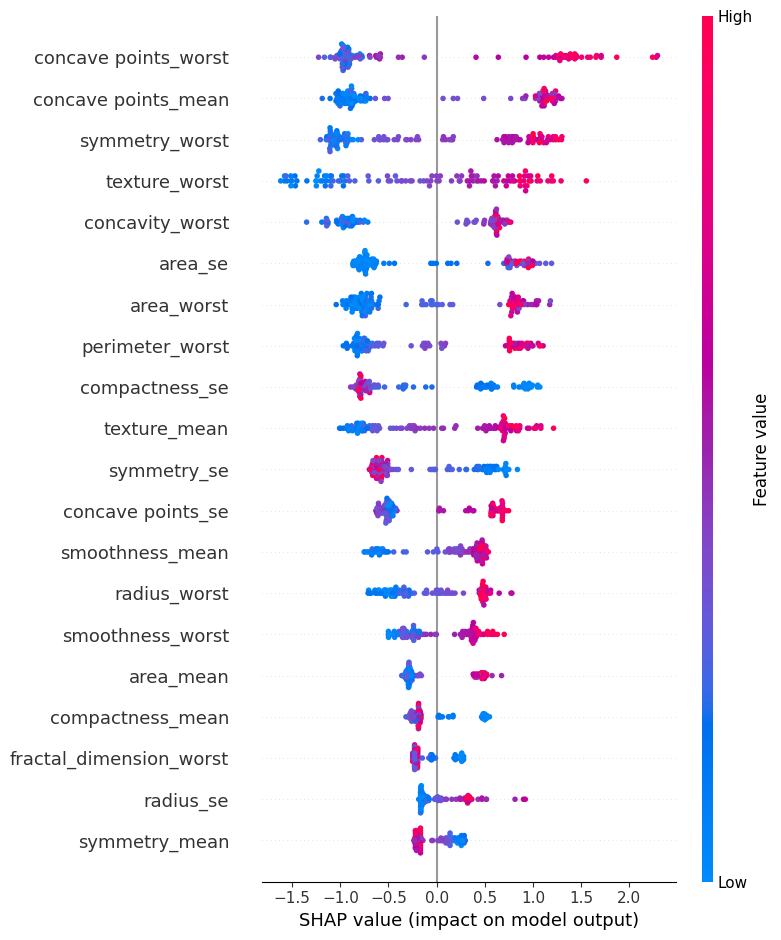

In [39]:
# this recommended by AI 
explainer = shap.Explainer(model.best_estimator_)
shap_values = explainer(X_test)
plt.figure(figsize=(20,10))
shap.summary_plot(shap_values, X_test)
